In [119]:
%matplotlib inline
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, learning_curve
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
plt.style.use('ggplot')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Loading data

In [5]:
data_path = 'CrowdstormingDataJuly1st.csv'
raw_data = pd.read_csv(data_path)

In [6]:
raw_data.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


# Process data, extract features and labels

Remove entries with both skin tone rating not available

In [7]:
data = raw_data.dropna(how='all', subset=['rater1', 'rater2'])

Extract relevant features and remove NaN values

In [13]:
features = data.loc[:, data.dtypes != object].copy()

# Remove columns which will be used as label
features.drop(['rater1', 'rater2'], axis=1, inplace=True)

# Remove player with NaN values in the numerical data
features.dropna(inplace=True)
features.head()

,height,weight,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,refNum,refCountry,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,177.0,72.0,1,0,0,1,0,0,0,0,1,1,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,179.0,82.0,1,0,0,1,0,1,0,0,2,2,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
5,182.0,71.0,1,0,0,1,0,0,0,0,4,4,0.325185,127.0,0.003297,0.538462,130.0,0.013752
6,187.0,80.0,1,1,0,0,0,0,0,0,4,4,0.325185,127.0,0.003297,0.538462,130.0,0.013752
7,180.0,68.0,1,0,0,1,0,0,0,0,4,4,0.325185,127.0,0.003297,0.538462,130.0,0.013752


Extract and create labels for the correspond features

In [17]:
# number of values for the skin tone values (0, 0.25, 0.50, 0.75, 1.0)
n_val = 5

# take de mean of the raters
labels = 0.5*(data.rater2 + data.rater1).copy()

# round values to their nearest n_val values
labels = ((n_val-1)*labels).round()/(n_val-1)

# remove labels that don't have their corresponding features
labels = labels[features.index]
labels.head()

0    0.50
1    0.75
5    0.00
6    0.00
7    1.00
dtype: float64

Rounding the values of the labels is usefull because the two raters have in general a large variance. So we decided to restrain the skin tone to have *n_val* values which are more meaningful.

Convert data to numpy array

In [18]:
y = np.asarray(labels, dtype="|S6")
X = features.as_matrix()
print('dimensions y =', y.shape)
print('dimensions X =', X.shape)

dimensions y = (123715,)
dimensions X = (123715, 18)


Split data into training and testing sets

In [158]:
# seed for the random number generator and for reproducibility
seed = 42

# split the data into training and testing sets
test_data_ratio = 0.05
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_data_ratio, random_state=seed)

# 1. Train a Random Forest Classifier

Define function to print accuracy of the model

In [187]:
def print_score(classifier, X_train, y_train, X_test, y_test):
    print('Train set score :', classifier.score(X_train, y_train))
    print('Test set score :', classifier.score(X_test, y_test))

Create, train and test the random forest classifier

In [188]:
rfc = RandomForestClassifier(n_jobs=-1)
model = rfc.fit(X_train, y_train)

print_score(rfc, X_train, y_train, X_test, y_test)

Train set score : 0.974151060589
Test set score : 0.605399288716


We clearly see that the model is overfitting. We can decrease the overfitting by increasing the number of maximum features

In [189]:
rfc = RandomForestClassifier(max_features=None, n_jobs=-1)
model = rfc.fit(X_train, y_train)

print_score(rfc, X_train, y_train, X_test, y_test)

Train set score : 0.971453853942
Test set score : 0.72453928225


# TODO
- Try other parameters
- Don't know what "Perform cross-validation to mitigate the overfitting of your model." means

Here is some code scraps :

In [190]:
## ---> Cross validation score <---
#scores = cross_val_score(rfc, X_train, y_train, cv=3)
#scores.mean()

## ---> Parameters search using grid search <---
#parameters = {'n_estimators': [5, 10, 15, 20],
#              'max_depth': [2, 5, 7, 9]}
#grid_rfc = GridSearchCV(rfc, parameters)
#grid_rfc.fit(X_train, y_train, oob_score=True)

## ---> K-fold score <---
#kfold = KFold(n_splits=20)
#kfold_score = [rfc.fit(X_train[train], y_train[train]).score(X_train[test], y_train[test])
#               for train, test in kfold.split(X_train)]
#kfold_score

## 1.1 Features importances

Starting by defining a function to plot the features importances

In [191]:
def plot_features_importances(ft_imp):
    plt.figure()
    ft_imp.plot(kind='bar')
    
    #plt.title('Feature importance for the trained random forest model')
    plt.xlabel('Feature name', fontweight='bold')
    plt.ylabel('Features importance [%]', fontweight='bold')
    plt.show()

Extract and plot the features importances

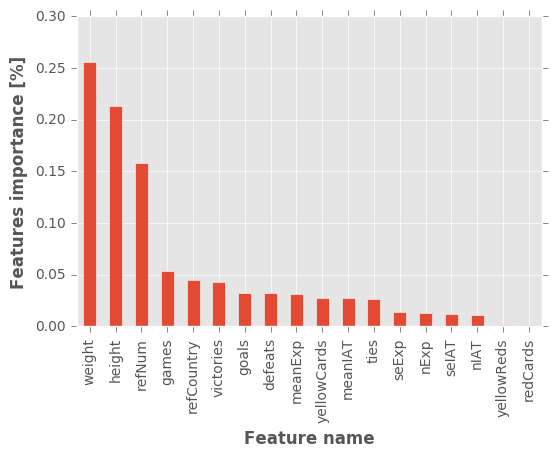

In [192]:
# Extract features importances from model
features_importances = model.feature_importances_

# Create series from features importances and features names
ft_imp = pd.Series(features_importances, index=features.columns.values).sort_values(ascending=False)

# Plot features
plot_features_importances(ft_imp)

Three features stands out : 'height', 'weight' and 'refNum'. We can try to use the first 6 most usefull features to train our random forest classifier

In [38]:
# number of features choosen
n_features = 6

# extract reduced features set and drop NaN values
features_reduced = data[ft_imp.head(n_features).index].copy()
features_reduced.dropna(inplace=True)

# extract and create reduced labels
labels_reduced = labels[features_reduced.index]

# show reduced features
features_reduced.head()

,weight,height,refNum,games,victories,refCountry
0,72.0,177.0,1,1,0,1
1,82.0,179.0,2,1,0,2
5,71.0,182.0,4,1,0,4
6,80.0,187.0,4,1,1,4
7,68.0,180.0,4,1,0,4


We can now train our random forest classifier on the reduced data set

In [39]:
# convert dataframe to numpy array
y_r = np.asarray(labels_reduced, dtype="|S6")
X_r = features_reduced.as_matrix()

# split data into training and testing sets
seed = 42
X_r_train, X_r_test, y_r_train, y_r_test = train_test_split(X_r, y_r, test_size=0.1, random_state=seed)

# create and train model
rfc_r = RandomForestClassifier(max_features=None, n_jobs=-1)
model_r = rfc_r.fit(X_r_train, y_r_train)

# compute score of the train model
print_score(rfc_r, X_r_train, y_r_train, X_r_test, y_r_test)

Train set score : 0.957696827262
Test set score : 0.68927100993


We can see that the model is not really better. Let's see the features importances

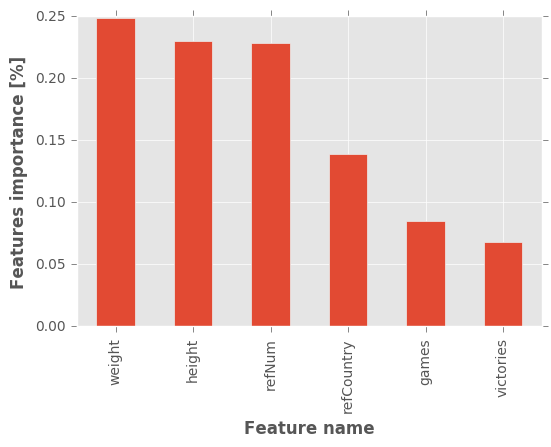

In [40]:
# Extract features importances from model
features_importances_reduced = model_r.feature_importances_

# Create series from features importances and features names
ft_imp = pd.Series(features_importances_reduced, index=features_reduced.columns.values).sort_values(ascending=False)

# Plot features
plot_features_importances(ft_imp)

The order of the features importance is similar but the player country has a higher importance than before

## 1.2 Learning curve

Compute learning curve of the random forest classifier for some fixed parameters. **Warning this cell is long to run**.

In [106]:
# set training batch sizes
training_sizes=np.array([0.1, 0.325, 0.55, 0.775, 1.])

# set n-folds cross validation
n_folds = 20

# compute learning curve
train_sizes, train_scores, valid_scores = learning_curve(RandomForestClassifier(max_features=None, n_jobs=-1), 
                                                                                X, y, train_sizes=training_sizes,
                                                                                cv=n_folds, n_jobs=-1)

Let's plot the results

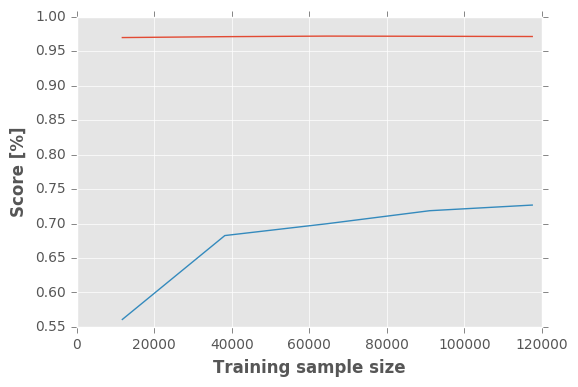

In [183]:
plt.figure()

plt.plot(train_sizes, train_scores.mean(axis=1))
plt.plot(train_sizes, valid_scores.mean(axis=1))

plt.xlabel('Training sample size', fontweight='bold')
plt.ylabel('Score [%]', fontweight='bold')

plt.show()

The learning curve shows that the model has a high variance

# TODO:
- Try different parameters set for the random forest classifier

# 2. Clustering using an unsupervised learning technique

Let's try a k-means clustering on the training data

In [159]:
kmeans_model = KMeans(n_clusters=2)
clust_model = kmeans_model.fit(X_train)

And now computing the silhouette score

In [160]:
silhouette_score(X_test, clust_model.predict(X_test))

0.99283450509500026

To see what happens if we remove a feature, we define the following function

In [161]:
def silhouette_score_droping_k_feature(X_train, X_test, k):
    
    X_tr = np.delete(X_train, k, axis=1)
    X_te = np.delete(X_test, k, axis=1)
    
    kmeans_model = KMeans(n_clusters=2)
    clust_model = kmeans_model.fit(X_tr)
    
    return silhouette_score(X_te, clust_model.predict(X_te))

Computing the score by removing the *k*-th feature. **Warning this cell is a bit long to run**.

In [162]:
score= []
for k in range(X.shape[1]):
    score.append(silhouette_score_droping_k_feature(X_train, X_test, k))

Then we visualize the score variation

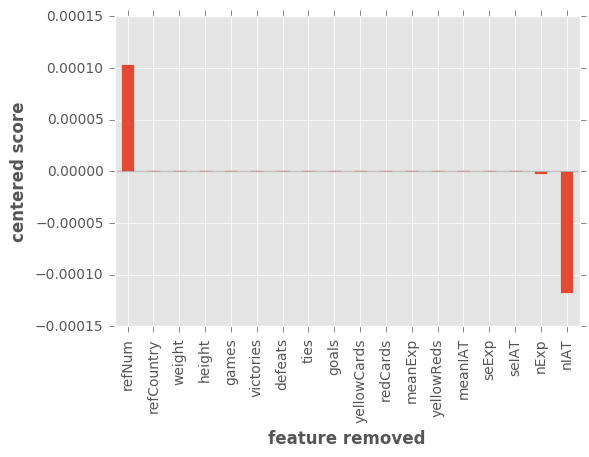

In [246]:
scores = pd.Series(score-np.mean(score), index=features.columns.values).sort_values(ascending=False)

scores.plot(kind='bar')
plt.hlines(0, -1, 18, colors=[0.3,0.3,0.3,0.3])

plt.xlabel('removed feature', fontweight='bold')
plt.ylabel('centered score', fontweight='bold')

plt.show()

We can see that that by removing the reference number we increase the score. And by remove the sample size for race IAT in that particular country we decrease the score.

# TODO
- Discussion of the results is too small
- Maybe try to remove other features